# Trend Analyser

### 
___

### Importing Libraries

In [1]:
import os
from dotenv import load_dotenv


load_dotenv()

True

### 
___

### Generating Queries (Need to Improve Prompt for Keyword Extraction)

In [2]:
import pandas as pd          
import PIL.Image
import google.generativeai as genai     

/Users/t.sumukhflexday/anaconda3/envs/fashion_trend/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
GOOGLE_API_KEY=os.getenv('API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('models/gemini-1.5-pro-latest')

In [7]:
img = PIL.Image.open("../data/Trend Analysis/pinterest/a4b7e7fa-fff0-3122-8508-ba87c5c4f042.png")


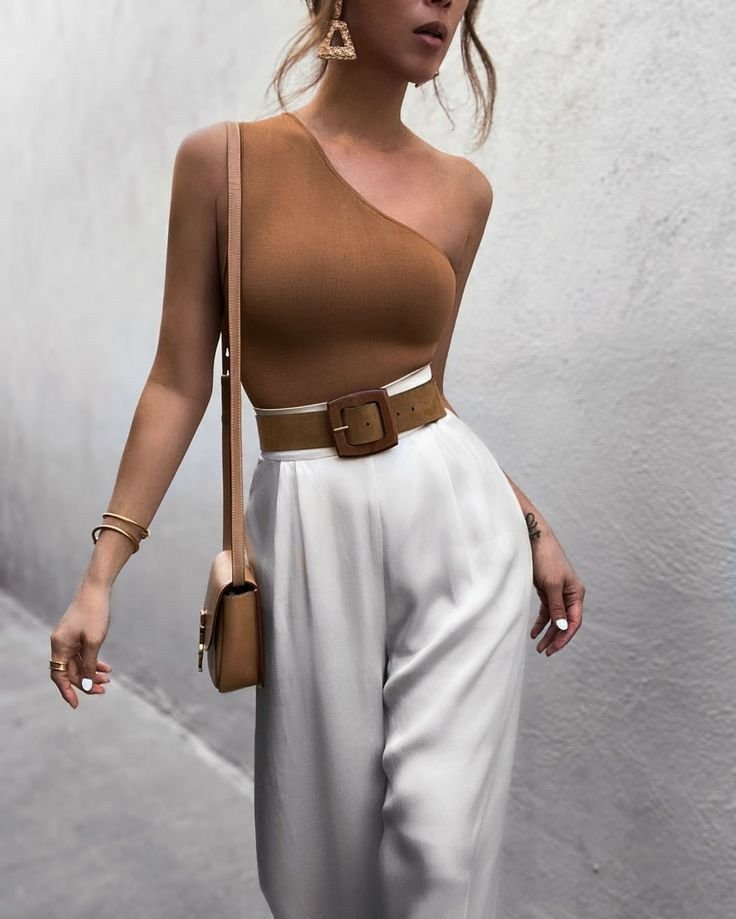

In [8]:
img

In [9]:
# KEY_WORD_EXTRACTION_PROMPT = """
# System: You are a fashion-savvy individual who enjoys finding trendy clothing online. Your task is to examine an image of a fashion item or outfit and generate search queries that an average person might use when trying to find similar items on shopping websites or search engines.
# When generating the search queries, focus on:

# The main type of clothing item (e.g., dress, top, pants)
# Distinctive colors or patterns
# Notable design features that catch the eye
# Overall style or occasion the outfit seems suited for

# The search queries should be natural and similar to what someone might actually type into a search bar. Avoid overly technical fashion terminology.

# Your output should be a list of 5 search queries with the following format:
# #Query 1#Query 2#Query 3#Query 4#Query 5

# Ensure that each query is realistic and directly relates to the main fashion items shown in the image.
# The Each Query should have onlt

# NOTE:
# The Each Query should be only 2 words long
# """


# KEY_WORD_EXTRACTION_PROMPT = """


# System: You are a fashion-savvy individual who enjoys finding trendy clothing online. Your task is to examine an image of a fashion item or outfit and generate short, concise search terms that an average person might use when trying to find similar items on shopping websites or search engines.

# When generating the search terms, focus on:

# - The main type of clothing item
# - Distinctive colors or patterns
# - Notable design features
# - Overall style or occasion

# The search terms should be natural and similar to what someone might actually type into a search bar. Avoid overly technical fashion terminology.

# Your output should be a list of 1 search terms with the following format:

# #Term1#Term2#Term3#Term4#Term5

# Guidelines:
# - Each term must be 1 words maximum
# - Ensure that each term is realistic and directly relates to the main fashion items shown in the image
# - Use terms an average person would type when searching online
# - Focus on the most noticeable aspects of the clothing

# Example output:
# #Red dress#Floral print
# """


# KEY_WORD_EXTRACTION_PROMPT = """ 
# You are an expert image analyst with a deep understanding of fashion and clothing. 
# You're tasked with generating keywords for an image of an outfit. Please follow these guidelines:

# 1. Analyze the image carefully, focusing on the outfit's key features.
# 2. Generate up to 5 highly relevant keywords or short phrases that best describe the dress.
# 3. Consider the following aspects:
#    - Color and pattern
#    - Style (e.g., formal, casual, vintage)
#    - Fabric type or texture


# 4. Ensure each keyword is concise and specific.
# 5. Do not include any analysis or explanation, just list the keywords.

# Based on the image provided, generate up to 5 keywords or short phrases that best describe the dress:

# # #keyword1#keyword2#keyword3#keyword4#keyword5
# """



KEY_WORD_EXTRACTION_PROMPT = """ 
You are an expert image analyst with a deep understanding of fashion and clothing. 
You're tasked with generating keywords for an image of an outfit. Please follow these guidelines:

1. Analyze the image carefully, focusing on the outfit's key features.
2. Generate up to 5 highly relevant keywords or short phrases that best describe the outfit.
3. Use general, simple terms that most people would commonly use when searching for similar outfits online.
4. Consider the following aspects:
   - Color and pattern
   - Style (e.g., formal, casual, vintage)
   - Fabric type or texture

5. Ensure each keyword is concise, specific, and easily understandable to the average person.
6. Avoid technical fashion terms or overly specific descriptors.
7. Do not include any analysis or explanation, just list the keywords.

Based on the image provided, generate up to 5 general, simple keywords or short phrases that best describe the outfit:

# #keyword1#keyword2#keyword3#keyword4#keyword5
"""

In [10]:

response = model.generate_content([KEY_WORD_EXTRACTION_PROMPT, img], stream=False)


In [11]:
print(response.text)

#one shoulder top 
#high waisted pants
#wide leg pants
#tan top
#white pants 



In [12]:

print(list(filter(lambda x: x != "" and x!= '<Search Queries:>',map(str.strip,response.text.split("#")))))

['one shoulder top', 'high waisted pants', 'wide leg pants', 'tan top', 'white pants']


### 
___

### Trends Extraction 

In [13]:
from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError
from time import sleep


In [14]:
pytrend = TrendReq()



In [15]:
search_keywords =list(map(lambda x: x + "", (filter(lambda x: x != "" and x!= '<Search Queries:>',map(str.strip,response.text.split("#"))))))
search_keywords


['one shoulder top',
 'high waisted pants',
 'wide leg pants',
 'tan top',
 'white pants']

In [16]:
# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
attempts, fetched = 0, False
while not fetched:
    try:
        pytrend.build_payload(kw_list=search_keywords,timeframe='today 3-m',geo='IN')
        interest_over_time_df = pytrend.interest_over_time()

    except ResponseError as err:
        print(err)
        print(f'Trying again in {15 + 5 * attempts} seconds.')
        sleep(60 + 5 * attempts)
        attempts += 1
        if attempts > 3:
            print('Failed after 3 attemps, abort fetching.')
            break
    else:
        fetched = True


# Interest Over Time
interest_over_time_df.drop(columns=['isPartial'], inplace=True)
interest_over_time_df.index = pd.to_datetime(interest_over_time_df.index)






### 
___

### Trend Visualization

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

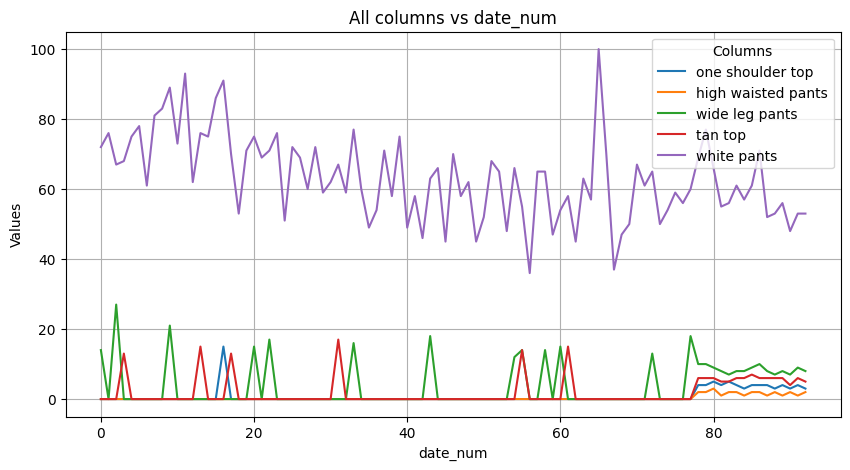

In [18]:
## Visualizing The Trend

filtered_df = interest_over_time_df.copy()
df_reset = filtered_df.reset_index()
df_reset['date_num'] = (df_reset['date'] - df_reset['date'].min()).dt.days
df_reset.drop(columns=['date'],inplace=True)

main_column = 'date_num'

melted_df = df_reset.melt(id_vars=[main_column], var_name='variable', value_name='value')

plt.figure(figsize=(10, 5))
sns.lineplot(data=melted_df, x=main_column, y='value', hue='variable')
plt.title(f'All columns vs {main_column}')
plt.xlabel(main_column)
plt.ylabel('Values')
plt.legend(title='Columns')
plt.grid(True)

plt.show()

### 
___

### Trend Fitting

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [20]:
def calculate_rolling_mean(df, window, iterations):
    rolling_df = df.copy()
    for _ in range(iterations):
        rolling_df = rolling_df.rolling(window=window,center=True).mean()
    return rolling_df

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

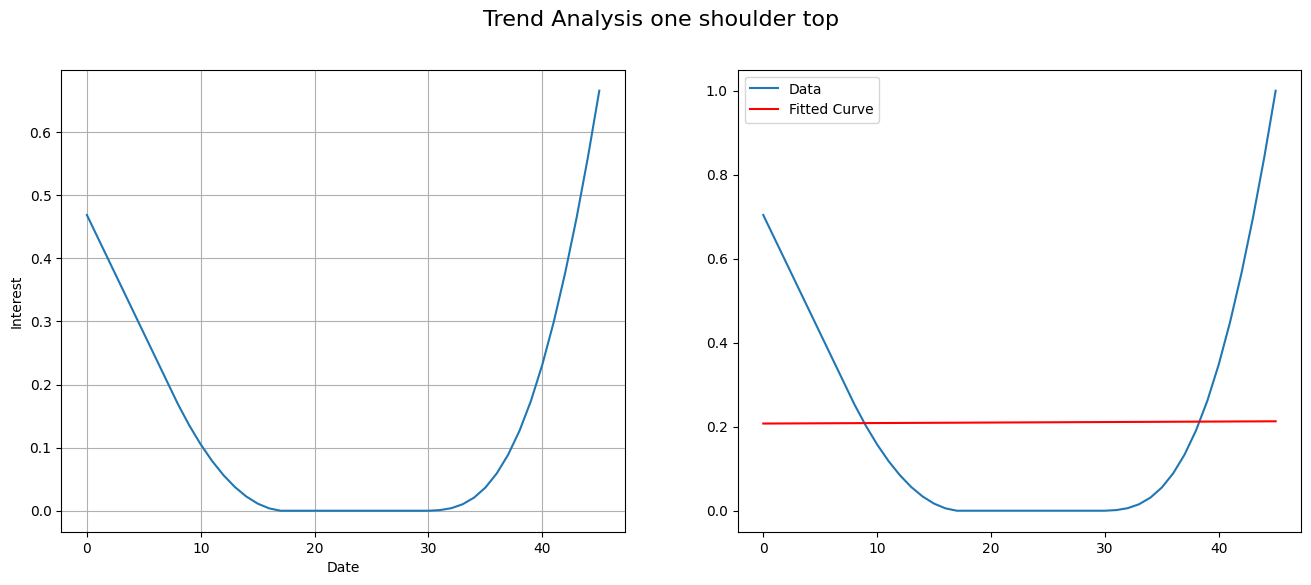

R-squared value: 3.519757804848478e-05
Fitted parameters: a = -32.4401080289779, b = -3.685110383606671e-06, c = 32.6476571763617
--------------------


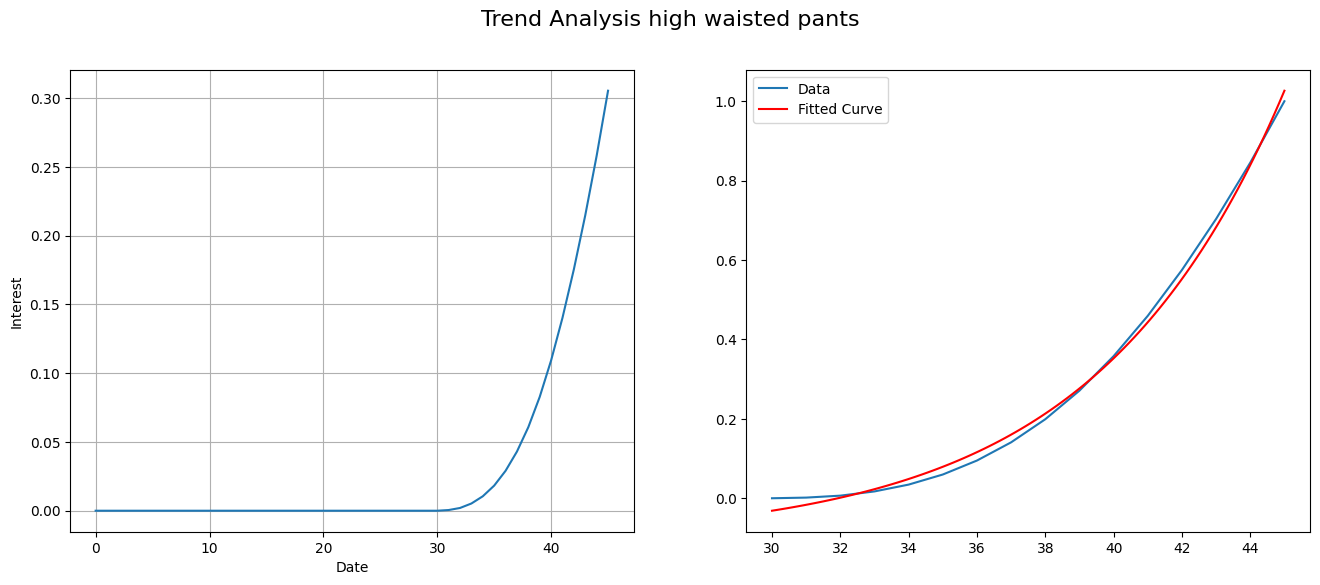

R-squared value: 0.9969038199185483
Fitted parameters: a = 0.00033382311074459483, b = 0.18066660933167203, c = -0.10680991357653939
--------------------


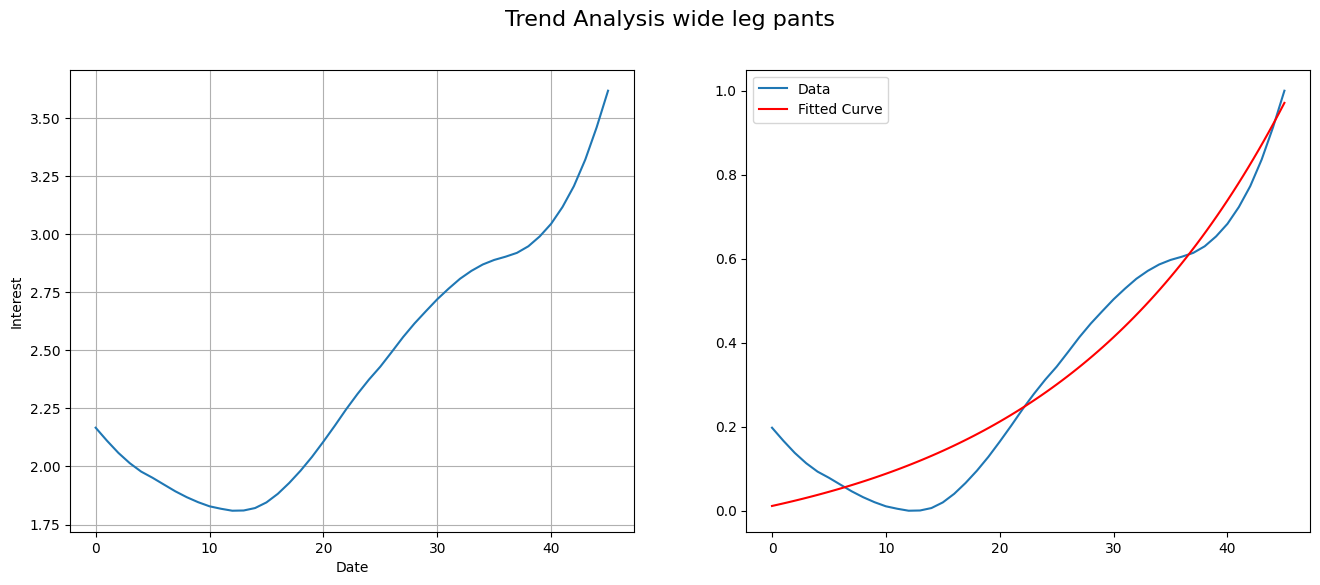

R-squared value: 0.9276831798331796
Fitted parameters: a = 0.12373029629393073, b = 0.04821782592874809, c = -0.11239306339474987
--------------------


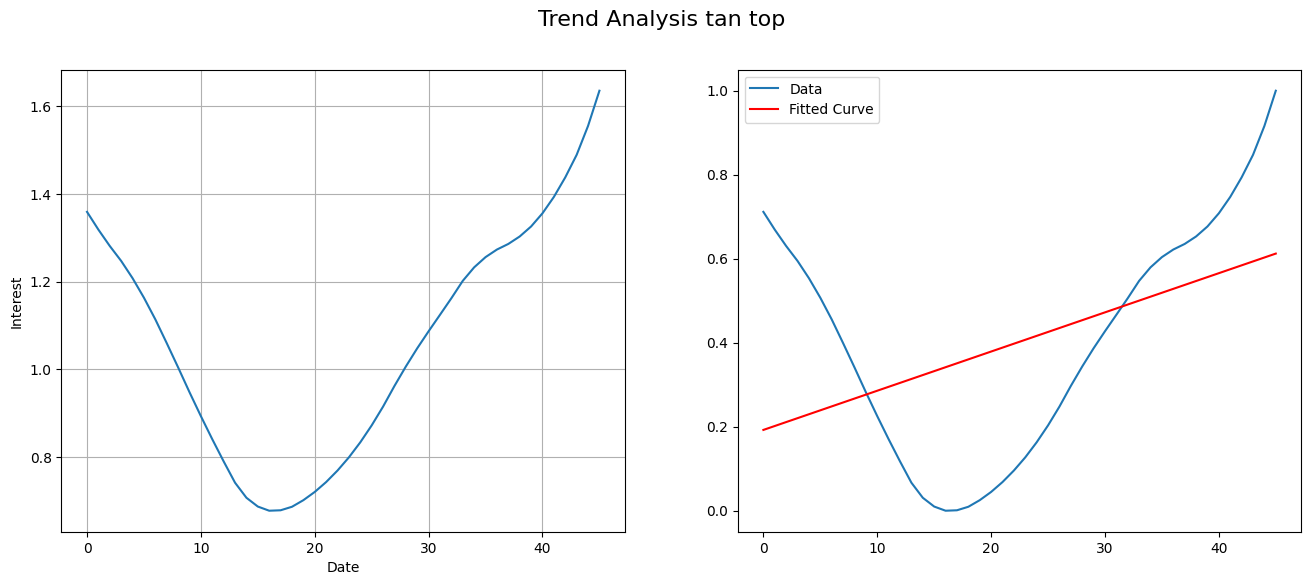

R-squared value: 0.19714825042583195
Fitted parameters: a = -3060.2542162921586, b = -3.0488378299384403e-06, c = 3060.446617762108
--------------------


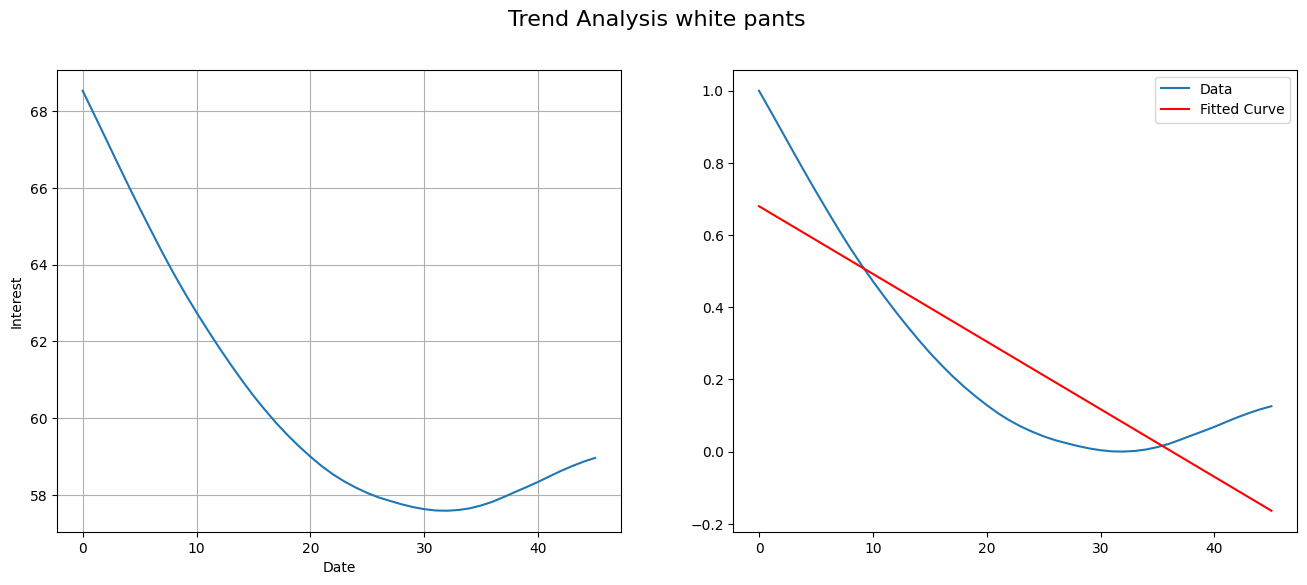

R-squared value: 0.7197372663507642
Fitted parameters: a = -3624.6915544268613, b = 5.1727965279232215e-06, c = 3625.3714681336946
--------------------


In [21]:
for index in range(len(filtered_df.columns)):
    if(filtered_df.columns[index]=="date_num"):continue
    # Smoothing The Trend Data by using Rolling Mean and Filtering to Include Only 2 months of data


    smoothen_df = calculate_rolling_mean(interest_over_time_df, window=20, iterations=2)
    smoothen_df = calculate_rolling_mean(smoothen_df, window=10, iterations=1)

    smoothen_df.dropna(inplace=True)


    filtered_df = smoothen_df.loc[smoothen_df.index >= pd.to_datetime('today') - pd.DateOffset(months=3)]
    filtered_df = filtered_df.reset_index()
    filtered_df['date_num'] = (filtered_df['date'] - filtered_df['date'].min()).dt.days
    filtered_df.drop(columns=['date'],inplace=True)


    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Trend Analysis {filtered_df.columns[index]}', fontsize=16)

    sns.lineplot(data=filtered_df, x='date_num', y=filtered_df.columns[index],ax=axs[0])
    # axs[0].set_title('Interest Over Time')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Interest')
    axs[0].grid(True) 


    x_data = np.array(filtered_df['date_num'])
    y_data = np.array(filtered_df[filtered_df.columns[index]])


    first_non_zero_index = np.argmax(y_data > 0) 
    if(first_non_zero_index):
        x_data = x_data[first_non_zero_index-1:]
        y_data = y_data[first_non_zero_index-1:]

        
    if(not np.all(y_data == 0)):
        x = x_data
        y  = (y_data - y_data.min()) / (y_data.max() - y_data.min())


        initial_guess = [1.0, 0.1, 0.0]  # Initial values for a, b, c

        # Fit the data to the exponential function with initial guess
        popt, pcov = curve_fit(exponential, x, y, p0=initial_guess, maxfev=10000)

        # Generate points for the fitted curve
        x_fit = np.linspace(min(x), max(x), 100)
        y_fit = exponential(x_fit, *popt)

        # Calculate R-squared value
        r_squared = r2_score(y, exponential(x, *popt))

        # Plot the results
        axs[1].plot(x, y, label='Data')
        axs[1].plot(x_fit, y_fit, 'r-', label='Fitted Curve')
        axs[1].legend()

        plt.show()

        print(f"R-squared value: {r_squared}")
        print(f"Fitted parameters: a = {popt[0]}, b = {popt[1]}, c = {popt[2]}",end="\n--------------------\n")

    else:
        plt.show()

        print("No Trend Found",end="\n--------------------\n")

    

### 
___

### Final Function 

#### Importing Libraries

In [ ]:
import os
from tqdm import tqdm
from dotenv import load_dotenv
         
import PIL.Image
import google.generativeai as genai     

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError
from time import sleep

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from collections import defaultdict

load_dotenv()

#### Initial Setup

In [ ]:
GOOGLE_API_KEY=os.getenv('API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)
llm_model = genai.GenerativeModel('models/gemini-1.5-pro-latest')

In [ ]:
pytrend = TrendReq()

#### Required Functions

In [ ]:
def query_keywords_generation_module(image_path:str,model:genai.GenerativeModel)-> list[str]:
    
    image = PIL.Image.open(image_path)

        
    KEY_WORD_EXTRACTION_PROMPT = """ 
    You are an expert image analyst with a deep understanding of fashion and clothing. 
    You're tasked with generating keywords for an image of an outfit. Please follow these guidelines:

    1. Analyze the image carefully, focusing on the outfit's key features.
    2. Generate up to 5 highly relevant keywords or short phrases that best describe the outfit.
    3. Use general, simple terms that most people would commonly use when searching for similar outfits online.
    4. Consider the following aspects:
    - Color and pattern
    - Style (e.g., formal, casual, vintage)
    - Fabric type or texture

    5. Ensure each keyword is concise, specific, and easily understandable to the average person.
    6. Avoid technical fashion terms or overly specific descriptors.
    7. Do not include any analysis or explanation, just list the keywords.

    Based on the image provided, generate up to 5 general, simple keywords or short phrases that best describe the outfit:

    # #keyword1#keyword2#keyword3#keyword4#keyword5
    """
    sleep(5)
    try:
        response = model.generate_content([KEY_WORD_EXTRACTION_PROMPT, image], stream=False)
    except:
        return []
    

    if("text:" not in str(response.candidates)): return []

    return(list(filter(lambda x: x != "" and x!= '<Search Queries:>',map(str.strip,response.text.split("#")))))


def trend_data_extraction_module(search_keywords:list[str],pytrend:TrendReq)-> pd.DataFrame:
    
    attempts, fetched = 0, False
    while not fetched:
        try:
            pytrend.build_payload(kw_list=search_keywords,timeframe='today 3-m',geo='IN')
            interest_over_time_df = pytrend.interest_over_time()
            interest_over_time_df.drop(columns=['isPartial'], inplace=True)
            interest_over_time_df.index = pd.to_datetime(interest_over_time_df.index)
            return interest_over_time_df


        except:
            print(f'Trying again in {15 + 5 * attempts} seconds.')
            sleep(10 + 5 * attempts)
            attempts += 1
            if attempts > 4:
                print('Failed after 4 attemps, abort fetching.')
                break
        else:
            fetched = True
        
        return pd.DataFrame()
    

    

def trend_visualization(df:pd.DataFrame):
    filtered_df = df.copy()
    df_reset = filtered_df.reset_index()
    df_reset['date_num'] = (df_reset['date'] - df_reset['date'].min()).dt.days
    df_reset.drop(columns=['date'],inplace=True)

    main_column = 'date_num'

    melted_df = df_reset.melt(id_vars=[main_column], var_name='variable', value_name='value')

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=melted_df, x=main_column, y='value', hue='variable')
    plt.title(f'All columns vs {main_column}')
    plt.xlabel(main_column)
    plt.ylabel('Values')
    plt.legend(title='Columns')
    plt.grid(True)

    plt.show()
    return


def calculate_rolling_mean(df:pd.DataFrame, window:int, iterations:int)-> pd.DataFrame:
    rolling_df = df.copy()
    for _ in range(iterations):
        rolling_df = rolling_df.rolling(window=window,center=True).mean()
    return rolling_df


def exponential(x:int, a:int, b:int, c:int)->int:
    return a * np.exp(b * x) + c


def curve_fiting_module(df:pd.DataFrame,show_plots:bool=True) -> dict[str:[int,list]]:
    
    fitted_trends_df = pd.DataFrame(columns=["Keywords","R2 Score","Slope","Trending"])
    
    for index in range(len(df.columns)):   
        
        if(df.columns[index]=="date_num"):continue
        # Smoothing The Trend Data by using Rolling Mean and Filtering to Include Only 2 months of data

        print("Serach Keyword: ",df.columns[index])

        smoothen_df = calculate_rolling_mean(df, window=20, iterations=2)
        smoothen_df = calculate_rolling_mean(smoothen_df, window=10, iterations=1)

        smoothen_df.dropna(inplace=True)


        filtered_df = smoothen_df.loc[smoothen_df.index >= pd.to_datetime('today') - pd.DateOffset(months=3)]
        filtered_df = filtered_df.reset_index()
        filtered_df['date_num'] = (filtered_df['date'] - filtered_df['date'].min()).dt.days
        filtered_df.drop(columns=['date'],inplace=True)


        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Trend Analysis {filtered_df.columns[index]}', fontsize=16)

        sns.lineplot(data=filtered_df, x='date_num', y=filtered_df.columns[index],ax=axs[0])
        # axs[0].set_title('Interest Over Time')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Interest')
        axs[0].grid(True)


        x_data = np.array(filtered_df['date_num'])
        y_data = np.array(filtered_df[filtered_df.columns[index]])


        first_non_zero_index = np.argmax(y_data > 0) 
        if(first_non_zero_index):
            x_data = x_data[first_non_zero_index-1:]
            y_data = y_data[first_non_zero_index-1:]

            
        if(not np.all(y_data == 0)):
            x = x_data
            y  = (y_data - y_data.min()) / (y_data.max() - y_data.min())


            initial_guess = [1.0, 0.1, 0.0]  # Initial values for a, b, c

            # Fit the data to the exponential function with initial guess
            popt, pcov = curve_fit(exponential, x, y, p0=initial_guess, maxfev=10000)

            # Generate points for the fitted curve
            x_fit = np.linspace(min(x), max(x), 100)
            y_fit = exponential(x_fit, *popt)

            # Calculate R-squared value
            r_squared = r2_score(y, exponential(x, *popt))

            # Plot the results
            axs[1].plot(x, y, label='Data')
            axs[1].plot(x_fit, y_fit, 'r-', label='Fitted Curve')
            axs[1].legend()
            

            row  = {"Keywords":df.columns[index],"R2 Score":r_squared,"Slope":popt[0],"Trending":popt[0]>=0}
            fitted_trends_df = pd.concat([fitted_trends_df,pd.DataFrame([row])],ignore_index=True)


            print(f"R-squared value: {r_squared}")
            print(f"Fitted parameters: a = {popt[0]}, b = {popt[1]}, c = {popt[2]}")

        else:
            
            row  = {"Keywords":df.columns[index],"R2 Score":0,"Slope":-1,"Trending":None}
            fitted_trends_df = pd.concat([fitted_trends_df,pd.DataFrame([row])],ignore_index=True)

            print("No Trend Found")

        
        if show_plots: plt.show()
        else: plt.close(fig)
        print("\n---------------------\n")


    return fitted_trends_df




#### Pipeline

In [ ]:
def trend_analysis_pipeline(df:pd.DataFrame,image_folder_path:str,genai_model:genai.GenerativeModel,pytrend:TrendReq,visualize_trend:bool = False)->pd.DataFrame:
    
    raw_data_for_prediction_df = pd.DataFrame(columns=["Image ID","Image Source", "Image Link","Keywords","R2 Score","Slope","Trending"])
    
    # raw_data_for_prediction_df = pd.read_csv("./output.csv")
    # Image_ID = list(raw_data_for_prediction_df['Image ID'])

    for index, row in tqdm(df.iterrows()):
        image_id,image_src,image_link = row 
        
        image_path = f"{image_folder_path}/{image_id}.png"

        # if(image_path in Image_ID):continue

        search_keywords = query_keywords_generation_module(image_path,genai_model)
        if(len(search_keywords)==0):continue
        
        trend_df = trend_data_extraction_module(search_keywords,pytrend)
        if(trend_df.empty):continue

        if(visualize_trend):trend_visualization(trend_df)
        fitted_trend_data = curve_fiting_module(trend_df,show_plots=visualize_trend)


        fitted_trend_data["Image ID"] = image_id
        fitted_trend_data["Image Source"] = image_src
        fitted_trend_data["Image Link"] = image_link
        raw_data_for_prediction_df = pd.concat([raw_data_for_prediction_df,fitted_trend_data],ignore_index=False)

        raw_data_for_prediction_df.to_csv("output.csv")
        
    return raw_data_for_prediction_df

#### Usecase Example

In [ ]:
image_folder_path = "../data/myntra"
pinterest_df = pd.read_csv(f"{image_folder_path}/myntra_trend.csv")


In [ ]:
raw_data_for_prediction_df = trend_analysis_pipeline(pinterest_df,image_folder_path,llm_model,pytrend)